# The Forest Fire Model
## A rapid introduction to Mesa

O [Florest Fire Model](http://en.wikipedia.org/wiki/Forest-fire_model) é um dos exemplos mais simples de um modelo que exibe criticidade auto-organizada.

Mesa é uma nova estrutura de modelagem baseada em agentes Pythonic. Uma grande vantagem de usar Python é que é uma ótima linguagem para análise interativa de dados. Ao contrário de algumas outras estruturas ABM, com Mesa você pode escrever um modelo, executá-lo e analisá-lo, tudo no mesmo ambiente. (Você não precisa, é claro. Mas você pode).

Neste caderno, faremos uma introdução rápida à construção e análise de um modelo com Mesa.

Primeiro, algumas importações. Vamos ver o que todas as Mesa significam logo abaixo.

In [1]:
!apt-get install -y ffmpeg
!pip install mesa==0.8.9

import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter

from mesa import Model, Agent
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.9/668.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.8 MB/s eta 0:00:00


## Construindo o modelo

A maioria dos modelos consiste basicamente em duas coisas: agentes e um mundo para os agentes estarem. O modelo Forest Fire tem apenas um tipo de agente: uma árvore. Uma árvore pode estar não queimada, em chamas ou já queimada. O ambiente é uma grade, onde cada célula pode estar vazia ou conter uma árvore.

Primeiro, vamos definir nosso agente de árvore. O agente precisa ser atribuído a uma célula na grade, e é isso. Poderíamos atribuir aos agentes uma condição para estarem, mas por enquanto vamos fazer com que todos comecem como 'Fine'. Como o agente não se move, usamos `FixedAgent` como a classe pai.

Em seguida, definimos o método **step** do agente. Ele é chamado sempre que o agente precisa agir no mundo. O comportamento da árvore é simples: se estiver em chamas, ela espalha o fogo para todas as árvores vizinhas que não estejam queimando ou não tenham queimado.

In [2]:
class TreeCell(Agent):
    """
    Uma célula de árvore.

    Attributes:
        condição: "Fine", "On Fire", ou "Burned Out"

    """

    def __init__(self, unique_id, model, pos):
        """
        Criando uma nova árvore.
        Args:
            model: referência de modelo padrão para agente.
        """

        super().__init__(unique_id, model)
        self.pos = pos
        self.condition = "Fine"  # Estado inicial da árvore (não queimada)

    def step(self):
        """
        Se a árvore está em chamas, ela espalha o fogo para as árvores vizinhas.
        """
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

Agora precisamos definir o objeto do modelo em si. A principal coisa que o modelo precisa é da grade, na qual as árvores são colocadas. Podemos escolher diferentes tipos de grades, como uma grade de von Neumann, onde qualquer célula tem 4 vizinhos (esquerda, direita, superior e inferior) ou uma grade de Moore, onde uma célula tem oito vizinhos.

O modelo também precisa de alguns parâmetros: quão grande é a grade e qual será a densidade de árvores nela. A densidade será o parâmetro-chave que exploraremos abaixo.

Finalmente, daremos ao modelo um coletor de dados. Este é um objeto Mesa que coleta e armazena dados no modelo enquanto ele é executado para análise posterior.

O construtor precisa fazer algumas coisas. Ele instancia todas as variáveis ​​e objetos de nível de modelo; ele coloca árvores aleatoriamente na grade, com base no parâmetro de densidade; e ele inicia o fogo definindo todas as árvores em uma borda da grade (x=0) como On "Fire".

Em seguida, o modelo precisa de um método **step**.  Assim como no nível do agente, esse método define o que acontece em cada etapa do modelo. Queremos ativar todas as árvores, uma de cada vez; então, executamos o coletor de dados para contar quantas árvores estão atualmente em chamas, queimadas ou ainda bem. Se não houver mais árvores em chamas, paramos o modelo definindo sua propriedade **running** como False.

In [3]:
class ForestFire(Model):
    """
    Modelo de incêndio florestal simples.
    """

    def __init__(self, width=100, height=100, density=0.65, seed=None):
        """
        Cria um novo modelo de floresta.

        Args:
            width, height: Tamanho do grid do modelo
            density: Fração das células do grid tem em uma árvore.
        """
        super().__init__(seed=seed)

        # Configurações do modelo
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.density = density
        self.running = True

        # Coletor de dados para rastrear o estado das árvores
        self.datacollector = DataCollector(
            {
                "Fine": lambda m: self.count_type(m, "Fine"),
                "On Fire": lambda m: self.count_type(m, "On Fire"),
                "Burned Out": lambda m: self.count_type(m, "Burned Out"),
            }
        )

        # Colocando as árvores na grade com base na densidade
        for x in range(width):
            for y in range(height):
                if self.random.random() < density:
                    new_tree = TreeCell(self.next_id(), self, (x, y))
                    # Colocar as árvores da primeira coluna em chamas
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid.place_agent(new_tree, (x, y))
                    self.schedule.add(new_tree)

        # Coleta inicial dos dados
        self.datacollector.collect(self)

    def step(self):
        """
        Avança o modelo em um passo.
        """
        self.schedule.step()
        self.datacollector.collect(self)

        # Para a simulação se não houver mais árvores em chamas
        if self.count_type(self, "On Fire") == 0:
            self.running = False

    @staticmethod
    def count_type(model, tree_condition):
        """
        Conta o número de árvores em uma determinada condição.
        """
        return sum(1 for tree in model.schedule.agents if tree.condition == tree_condition)

    def get_forest_grid(self):
        """
        Gera uma matriz numérica representando o estado atual da grade.
        """
        grid = np.zeros((self.grid.width, self.grid.height))
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                cell_contents = self.grid.get_cell_list_contents((x, y))
                if cell_contents:
                    tree = cell_contents[0]
                    if tree.condition == "Fine":
                        grid[x, y] = 0
                    elif tree.condition == "On Fire":
                        grid[x, y] = 1
                    elif tree.condition == "Burned Out":
                        grid[x, y] = 2

        return grid

## Executando o modelo

Vamos criar um modelo com uma grade de 100 x 100 e uma densidade de árvore de 0,6. Lembre-se, ForestFire pega os argumentos **altura**, **largura**, **densidade**.

Para executar o modelo até que ele esteja pronto (isto é, até que ele defina sua propriedade **running** como False), basta usar o método **run_model()**. Isso é implementado no objeto pai Model, então não precisamos implementá-lo acima.

In [ ]:
fire = ForestFire(100, 100, 0.6)

In [ ]:
fire.run_model()

Agora podemos colocar os dados que ele coletou em um DataFrame do pandas:

<Axes: >

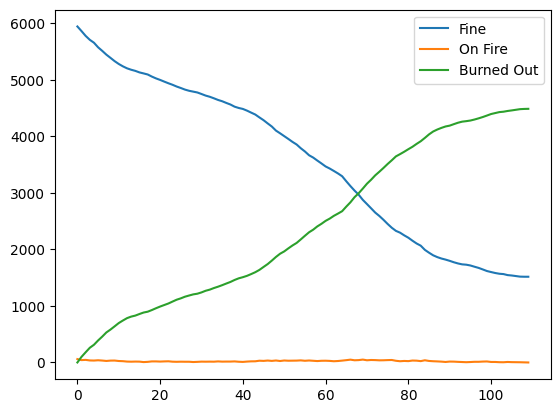

In [ ]:
results = fire.datacollector.get_model_vars_dataframe()
results.plot()

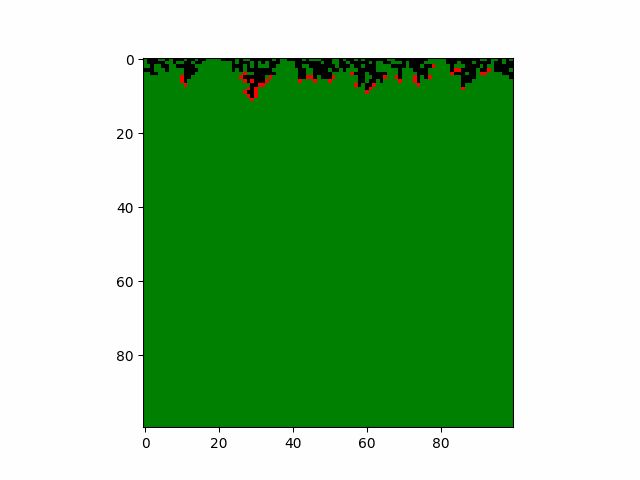

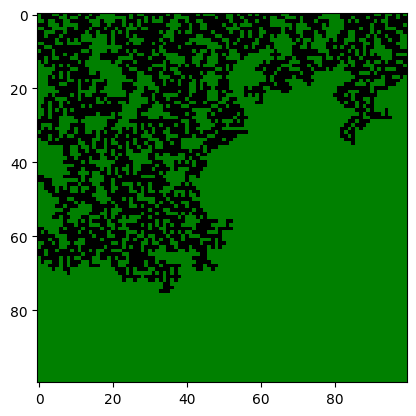

In [4]:
# Cores para os estados das árvores
COLOR_MAP = { "Fine": 0, "On Fire": 1, "Burned Out": 2}
COLORS = ["green", "red", "black"]

# Inicializa o modelo
model = ForestFire(100, 100, 0.6)

# Criação da figura e da grade inicial
fig, ax = plt.subplots()
initial_grid = model.get_forest_grid()  # Obtém o estado inicial da grade
im = ax.imshow(initial_grid, cmap=ListedColormap(COLORS), vmin=0, vmax=2)

def update(frame):
    """
    Executa um passo do modelo e atualiza a visualização.
    """
    model.step()  # Executa um passo do modelo
    grid = model.get_forest_grid()  # Obtém o estado atualizado da grade

    # Atualizar os dados da imagem com a nova matriz de estados
    im.set_data(grid)
    return [im]

# Configurar a animação e salvar como GIF
ani = FuncAnimation(fig, update, frames=range(100), interval=100, blit=True)
ani.save("forest_fire_simulation.gif", writer=PillowWriter(fps=10))

# Exibir o GIF no Colab
from IPython.display import Image
Image(filename="forest_fire_simulation.gif")

Neste caso, o fogo se extinguiu após cerca de 90 passos, com muitas árvores deixadas sem queimar.

Você pode tentar alterar o parâmetro de densidade e executar novamente o código acima, para ver como diferentes densidades produzem diferentes dinâmicas. Por exemplo:

<Axes: >

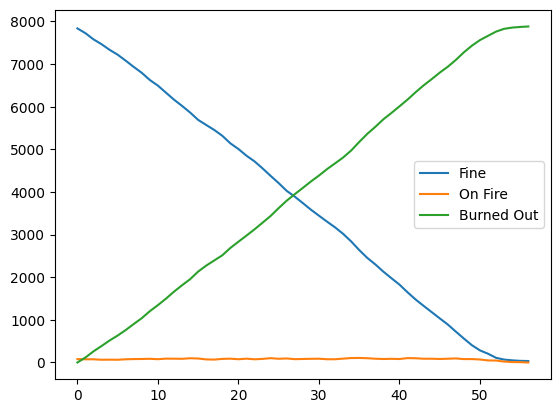

In [5]:
model = ForestFire(100, 100, 0.8)
model.run_model()
results = model.datacollector.get_model_vars_dataframe()
results.plot()

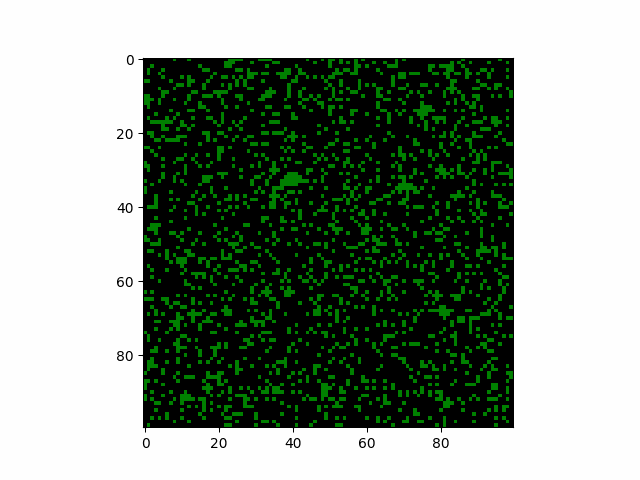

In [6]:
ani = FuncAnimation(fig, update, frames=range(200), interval=100, blit=True)
ani.save("forest_fire_simulation2.gif", writer=PillowWriter(fps=10))

# Exibição do GIF no Colab
from IPython.display import Image
Image(filename="forest_fire_simulation2.gif")

... Mas para realmente entender como o resultado final varia com a densidade, não podemos simplesmente ajustar o parâmetro manualmente repetidamente. Precisamos fazer uma execução em lote.

## Execuções em lote

Execuções em lote, também chamadas de varreduras de parâmetros, permitem que o usuário varra sistematicamente o parâmetro de densidade, execute o modelo e verifique a saída. O Mesa fornece um objeto BatchRunner que pega uma classe de modelo, um dicionário de parâmetros e o intervalo de valores que eles podem assumir e executa o modelo em cada combinação desses valores. Também podemos dar a ele repórteres, que coletam alguns dados no modelo no final de cada execução e os armazenam, associados aos parâmetros que os produziram.

Para facilitar a digitação e a leitura, primeiro criaremos os parâmetros para variar e o repórter e, em seguida, os atribuiremos a um novo BatchRunner.

In [ ]:
fixed_params = {"height": 50, "width": 50}  # Height and width are constant
# Vary density from 0.01 to 1, in 0.01 increments:
variable_params = {"density": np.linspace(0, 1, 101)[1:]}

In [ ]:
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {
    "BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / len(m.schedule.agents))
}

In [ ]:
# Create the batch runner
param_run = BatchRunner(
    ForestFire,
    variable_parameters=variable_params,
    fixed_parameters=fixed_params,
    model_reporters=model_reporter,
)

Agora, o BatchRunner, que chamamos de param_run, está pronto para ser executado. Para executar o modelo em todas as combinações de parâmetros (neste caso, todos os valores de densidade), basta usar o método **run_all()**.

In [ ]:
param_run.run_all()

100it [00:06, 15.30it/s]


Assim como com o coletor de dados, podemos extrair os dados coletados pelo executor de lote em um dataframe:

In [ ]:
df = param_run.get_model_vars_dataframe()

In [ ]:
df.head()

,density,Run,BurnedOut,height,width
0,0.01,0,0.033333,50,50
1,0.02,1,0.018519,50,50
2,0.03,2,0.012658,50,50
3,0.04,3,0.018868,50,50
4,0.05,4,0.015152,50,50


Como você pode ver, cada linha aqui é uma execução do modelo, identificada por seus valores de parâmetro (e dado um índice exclusivo pela coluna Run). Para visualizar como a fração BurnedOut varia com a densidade, podemos facilmente apenas plotá-las:

(0.0, 1.0)

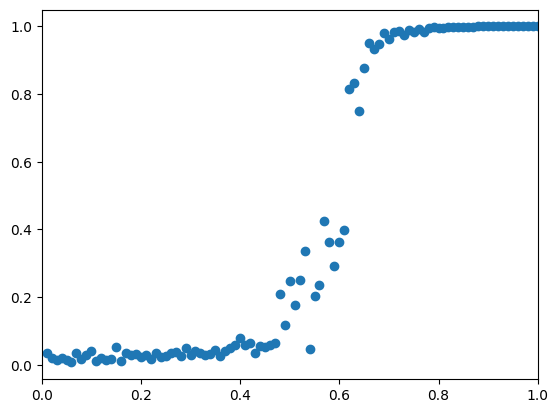

In [ ]:
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0, 1)

E vemos o surgimento muito claro de um valor crítico em torno de 0,5, onde o modelo muda rapidamente de quase nenhuma árvore sendo queimada para quase todas elas.

Neste caso, executamos o modelo apenas uma vez em cada valor. No entanto, é fácil fazer com que o BatchRunner execute várias execuções em cada combinação de parâmetros, a fim de gerar resultados estatisticamente mais confiáveis. Fazemos isso usando o argumento *iteration*.

Vamos executar o modelo 5 vezes em cada ponto de parâmetro e exportar e plotar os resultados como acima.

500it [00:37, 13.38it/s]


(0.0, 1.0)

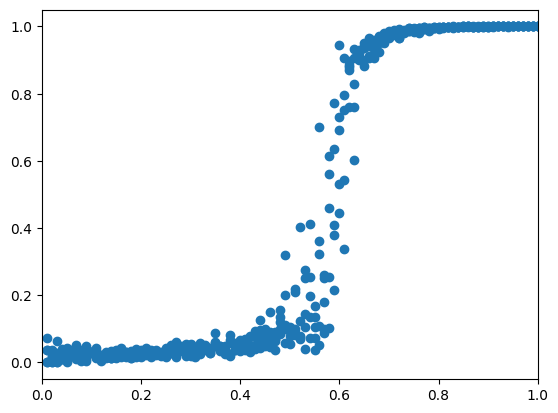

In [ ]:
param_run = BatchRunner(
    ForestFire,
    variable_params,
    fixed_params,
    iterations=5,
    model_reporters=model_reporter,
)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0, 1)

#**Adicionando Bombeiro Terrestre**

In [9]:
class GroundFirefighter(Agent):
    def __init__(self, unique_id, model, pos):
        super().__init__(unique_id, model)
        self.pos = pos

    def step(self):
        # Verifica se há uma árvore em chamas na posição atual
        current_cell = self.model.grid.get_cell_list_contents(self.pos)
        tree = next((obj for obj in current_cell if isinstance(obj, TreeCell)), None)

        if tree and tree.condition == "On Fire":
            tree.condition = "Fire Off"
            print(f"Bombeiro Terrestre apagou fogo na posição: {self.pos}")
        else:
            # Mover em direção à árvore em chamas mais próxima
            fire_positions = [
                (agent.pos, agent) for agent in self.model.schedule.agents
                if isinstance(agent, TreeCell) and agent.condition == "On Fire"
            ]
            if fire_positions:
                # Escolhe a árvore em chamas mais próxima
                closest_fire = min(fire_positions, key=lambda f: ((self.pos[0] - f[0][0]) ** 2 + (self.pos[1] - f[0][1]) ** 2) ** 0.5)[0]
                self.model.grid.move_agent(self, closest_fire)
                print(f"Bombeiro Terrestre se moveu para {closest_fire}")

In [10]:
class ForestFire(Model):
    def __init__(self, width=20, height=20, density=0.6, seed=None):
        super().__init__(seed=seed)
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.density = density
        self.running = True

        # Colocando árvores na grade com base na densidade
        for x in range(width):
            for y in range(height):
                if random.random() < self.density:
                    tree = TreeCell(self.next_id(), self, (x, y))
                    if x == 0:  # Incêndio começa na primeira coluna
                        tree.condition = "On Fire"
                    self.grid.place_agent(tree, (x, y))
                    self.schedule.add(tree)

        # Adicionando o bombeiro em uma posição inicial aleatória
        firefighter_position = (self.random.randrange(width), self.random.randrange(height))
        firefighter = GroundFirefighter(self.next_id(), self, firefighter_position)
        self.grid.place_agent(firefighter, firefighter_position)
        self.schedule.add(firefighter)

        # Coletor de dados para rastrear o estado das árvores
        self.datacollector = DataCollector(
            {
                "Fine": lambda m: self.count_type(m, "Fine"),
                "On Fire": lambda m: self.count_type(m, "On Fire"),
                "Burned Out": lambda m: self.count_type(m, "Burned Out"),
                "Fire Off": lambda m: self.count_type(m, "Fire Off"),
            }
        )
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        if self.count_type(self, "On Fire") == 0:
            self.running = False

    @staticmethod
    def count_type(model, tree_condition):
        return sum(1 for tree in model.schedule.agents if isinstance(tree, TreeCell) and tree.condition == tree_condition)

    def get_forest_grid(self):
        grid = np.zeros((self.grid.width, self.grid.height))
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                cell_contents = self.grid.get_cell_list_contents((x, y))
                if cell_contents:
                    tree = next((obj for obj in cell_contents if isinstance(obj, TreeCell)), None)
                    if tree:
                        if tree.condition == "Fine":
                            grid[x, y] = 0
                        elif tree.condition == "On Fire":
                            grid[x, y] = 1
                        elif tree.condition == "Burned Out":
                            grid[x, y] = 2
                        elif tree.condition == "Fire Off":
                            grid[x, y] = 3  # Representa o estado apagado pelo bombeiro
        return grid

Bombeiro Terrestre se moveu para (3, 93)


AttributeError: 'GroundFirefighter' object has no attribute 'condition'

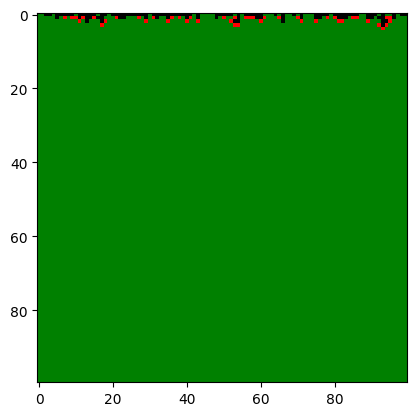

In [11]:
# Cores para os estados das árvores
COLOR_MAP = { "Fine": 0, "On Fire": 1, "Burned Out": 2, "Fire Off": 3}
COLORS = ["green", "red", "black", "blue"]

# Inicializa o modelo
model = ForestFire(100, 100, 0.6)

# Criação da figura e da grade inicial
fig, ax = plt.subplots()
initial_grid = model.get_forest_grid()  # Obtém o estado inicial da grade
im = ax.imshow(initial_grid, cmap=ListedColormap(COLORS), vmin=0, vmax=3)

def update(frame):
    """
    Executa um passo do modelo e atualiza a visualização.
    """
    model.step()  # Executa um passo do modelo
    grid = model.get_forest_grid()  # Obtém o estado atualizado da grade

    # Atualizar os dados da imagem com a nova matriz de estados
    im.set_data(grid)
    return [im]

# Configurar a animação e salvar como GIF
ani = FuncAnimation(fig, update, frames=range(100), interval=100, blit=True)
ani.save("forest_fire_simulation.gif", writer=PillowWriter(fps=10))

# Exibir o GIF no Colab
from IPython.display import Image
Image(filename="forest_fire_simulation.gif")